<h1 align='center'>It Starts with a Research Question...</h1>
<img src='Schmidt Fig 1.png' width="66%" height="66%">

# Word2Vec

This lesson is designed to explore features of word embeddings produced through the word2vec model. The questions we ask in this lesson are guided by Ben Schmidt's blog post <a href = "http://bookworm.benschmidt.org/posts/2015-10-30-rejecting-the-gender-binary.html">Rejecting the Gender Binary</a>.

The primary corpus we wil use consists of the <a href="http://txtlab.org/?p=601">150 English-language novels</a> made available by the <em>.txtLab</em> at McGill University. We also look at a <a href="http://ryanheuser.org/word-vectors-1/">Word2Vec model trained on the ECCO-TCP corpus</a> of 2,350 eighteenth-century literary texts made available by Ryan Heuser. (Note that the number of terms in the model has been shortened by half in order to conserve memory.)

For further technical background on Word2Vec's mechanics, I suggest this <a href="https://chromium.googlesource.com/external/github.com/tensorflow/tensorflow/+/refs/heads/0.6.0/tensorflow/g3doc/tutorials/word2vec/index.md">brief tutorial</a> by Google, especially the sections "Motivation," "Skip-Gram Model," and "Visualizing."

### Tutorial Agenda
<ul>
<li>Vector-Space Model of Language</li>
<li>Import & Pre-Processing</li>
<li>Word2Vec</li>
<ul><li>Training</li>
<li>Embeddings</li>
<li>Visualization</li>
</ul>
<li>Saving/Loading Models</li>
</ul>
<li>Topic Models</li>
</ul>

# 0. Vector-Space Model of Language
In the first day of this workshop, we explored the strange way that computers read text: by splitting it into tokens and tallying their frequencies. A novel or album review is reduced to a series of word counts. Since then, we have used simple arithmetic and statistics to identify patterns across those tallies. However, it is often useful to consider these patterns from another perspective: geometry.

Each text can be described as a series of word counts. What if we treated those like coordinates in space?

### Prep for visualization

In [1]:
%pylab inline
matplotlib.style.use('ggplot')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Create a DTM with a Few Pseudo-Texts

In [2]:
# dataframes!
import pandas

# Construct dataframe
columns = ['eggs','sausage','bacon']
indices = ['Novel A', 'Novel B', 'Novel C']
dtm = [[50,60,60],[90,10,10], [20,70,70]]
dtm_df = pandas.DataFrame(dtm, columns = columns, index = indices)

# Show dataframe
dtm_df

,eggs,sausage,bacon
Novel A,50,60,60
Novel B,90,10,10
Novel C,20,70,70


### Visualize

(Text(0.5, 0, 'eggs'), Text(0, 0.5, 'sausage'))

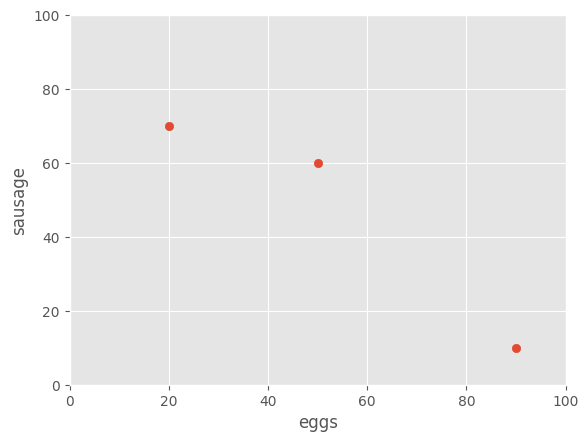

In [3]:
# Plot our points
scatter(dtm_df['eggs'], dtm_df['sausage'])

# Make the graph look good
xlim([0,100]), ylim([0,100])
xlabel('eggs'), ylabel('sausage')

### Vectors

At a glance, a couple of points are lying closer to one another. We used the word frequencies of just two words in order to plot our texts in a two-dimensional plane. The term frequency "summaries" of <i>Novel A</i> & <i>Novel C</i> are pretty similar to one another: they both share a major concern with "eggs", whereas <i>Novel B</i> seems to focus primarily on "sausage."

This raises a question: how can we operationalize our intuition that spatial distance expresses topical similarity?

<img src='Dot-Product.png' >

The most common measurement of distance between points is their <a href="https://en.wikipedia.org/wiki/Cosine_similarity">Cosine Similarity</a>. Imagine that we draw an arrow from the origin of the graph -- point (0,0) -- to the dot representing each text. This arrow is called a <i>vector</i>. The Cosine Similarity between two vectors measures how much they overlap with one another. Values for the cosine similarity between two vectors fall between 0 and 1, so they are easily interpreted and compared.

### Cosine Distance

In [4]:
# Although we want the Cosine Distance, it is mathematically
# simpler to calculate its opposite: Cosine Similarity

from sklearn.metrics.pairwise import cosine_similarity

In [5]:
# So we will subtract the similarities from 1

cos_sim = cosine_similarity(dtm_df)

In [6]:
# And we'll make it a little easier to read

np.round(cos_sim, 2)

array([[1.  , 0.64, 0.95],
       [0.64, 1.  , 0.35],
       [0.95, 0.35, 1.  ]])

In [7]:
#Compare the distance between novels

filelist = ['txtlab_Novel450_English/EN_1850_Hawthorne,Nathaniel_TheScarletLetter_Novel.txt',
            'txtlab_Novel450_English/EN_1851_Hawthorne,Nathaniel_TheHouseoftheSevenGables_Novel.txt',
            'txtlab_Novel450_English/EN_1920_Fitzgerald,FScott_ThisSideofParadise_Novel.txt',
            'txtlab_Novel450_English/EN_1922_Fitzgerald,FScott_TheBeautifulandtheDamned_Novel.txt',
            'txtlab_Novel450_English/EN_1811_Austen,Jane_SenseandSensibility_Novel.txt',
            'txtlab_Novel450_English/EN_1813_Austen,Jane_PrideandPrejudice_Novel.txt']

novel_names = ['Hawthorne: Scarlet Letter',
           'Hawthorne: Seven Gables',
           'Fitzgerald: This Side of Paradise',
           'Fitzgerald: Beautiful and the Damned',
           'Austen: Sense and Sensibility',
           'Austen: Pride and Prejudice']

text_list = []

for file in filelist:
    with open(file, 'r', encoding = 'utf-8') as myfile:
        text_list.append(myfile.read())

            

#import the function CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english', min_df = 3, binary=True)

novel_dtm = cv.fit_transform(text_list).toarray()
feature_list = cv.get_feature_names_out()
dtm_df_novel = pandas.DataFrame(novel_dtm, columns = feature_list, index = novel_names)
dtm_df_novel

,abandoned,abhorrence,abide,abilities,ability,able,aboard,abode,abominable,abominably,...,yielding,yonder,york,young,younger,youngest,youth,youthful,youths,zeal
Hawthorne: Scarlet Letter,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,0,1
Hawthorne: Seven Gables,1,0,1,1,1,1,1,1,1,0,...,1,1,0,1,1,1,1,1,0,1
Fitzgerald: This Side of Paradise,1,0,0,1,1,1,0,0,0,0,...,0,0,1,1,1,0,1,1,1,0
Fitzgerald: Beautiful and the Damned,1,1,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,0
Austen: Sense and Sensibility,1,1,0,1,1,1,0,1,0,1,...,0,0,0,1,1,1,1,1,0,1
Austen: Pride and Prejudice,0,1,1,1,0,1,0,1,1,1,...,1,0,1,1,1,1,1,0,1,0


In [8]:
cos_sim_novel = cosine_similarity(dtm_df_novel)
np.round(cos_sim_novel, 2)

array([[1.  , 0.8 , 0.69, 0.75, 0.67, 0.67],
       [0.8 , 1.  , 0.74, 0.8 , 0.7 , 0.7 ],
       [0.69, 0.74, 1.  , 0.78, 0.62, 0.61],
       [0.75, 0.8 , 0.78, 1.  , 0.69, 0.68],
       [0.67, 0.7 , 0.62, 0.69, 1.  , 0.81],
       [0.67, 0.7 , 0.61, 0.68, 0.81, 1.  ]])

In [9]:
cos_df = pandas.DataFrame(cos_sim_novel, columns = novel_names, index = novel_names)
cos_df

,Hawthorne: Scarlet Letter,Hawthorne: Seven Gables,Fitzgerald: This Side of Paradise,Fitzgerald: Beautiful and the Damned,Austen: Sense and Sensibility,Austen: Pride and Prejudice
Hawthorne: Scarlet Letter,1.000000,0.803744,0.692049,0.751001,0.669507,0.668908
Hawthorne: Seven Gables,0.803744,1.000000,0.738168,0.804472,0.704318,0.699387
Fitzgerald: This Side of Paradise,0.692049,0.738168,1.000000,0.784757,0.620796,0.609646
Fitzgerald: Beautiful and the Damned,0.751001,0.804472,0.784757,1.000000,0.690547,0.683669
Austen: Sense and Sensibility,0.669507,0.704318,0.620796,0.690547,1.000000,0.808900
Austen: Pride and Prejudice,0.668908,0.699387,0.609646,0.683669,0.808900,1.000000


/Users/angela/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


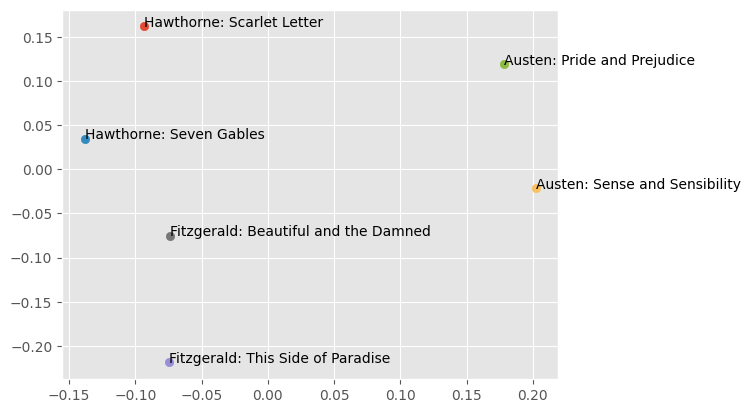

In [10]:
#visualizing differences

from sklearn.manifold import MDS

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

#transform cosine similarity to cosine distance
cos_dist = 1 - cosine_similarity(dtm_df_novel)

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(cos_dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

for x, y, name in zip(xs, ys, novel_names):
    plt.scatter(x, y)
    plt.text(x, y, name)

plt.show()

The above method has a broad range of applications, such as unsupervised clustering. Common techniques include <a href = "https://en.wikipedia.org/wiki/K-means_clustering">K-Means Clustering</a> and <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering">Heirchical Dendrograms</a>. These attempt to identify groups of texts with shared content, based on these kinds of distance measures.

Here's an example of a dendrogram based on these six novels:

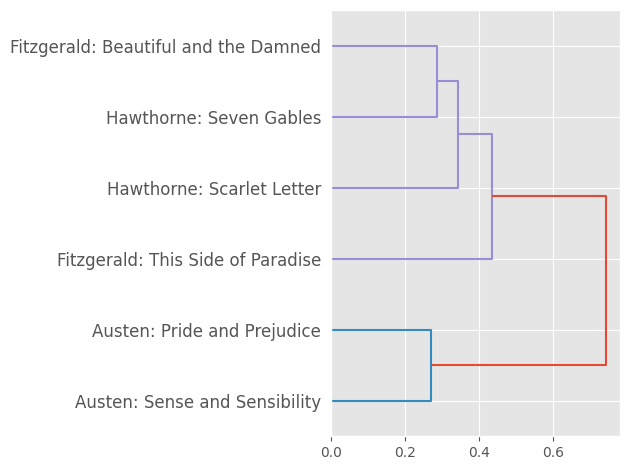

In [11]:
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(cos_dist)

dendrogram(linkage_matrix, orientation="right", labels=novel_names)

plt.tight_layout()  # fixes margins

plt.show()

### Vector Semantics

We can also turn this logic on its head. Rather than produce vectors representing texts based on their words, we will produce vectors for the words based on their contexts.

In [12]:
# Turn our DTM sideways

dtm_df_novel.T.head()

,Hawthorne: Scarlet Letter,Hawthorne: Seven Gables,Fitzgerald: This Side of Paradise,Fitzgerald: Beautiful and the Damned,Austen: Sense and Sensibility,Austen: Pride and Prejudice
abandoned,1,1,1,1,1,0
abhorrence,1,0,0,1,1,1
abide,1,1,0,0,0,1
abilities,1,1,1,0,1,1
ability,1,1,1,1,1,0


In [13]:
# Find the Cosine Distances between pairs of word-vectors

cos_sim_words = cosine_similarity(dtm_df_novel.T)

In [14]:
# In readable format

np.round(cos_sim_words, 2)

array([[1.  , 0.67, 0.52, ..., 0.89, 0.52, 0.77],
       [0.67, 1.  , 0.58, ..., 0.5 , 0.58, 0.58],
       [0.52, 0.58, 1.  , ..., 0.58, 0.33, 0.67],
       ...,
       [0.89, 0.5 , 0.58, ..., 1.  , 0.29, 0.87],
       [0.52, 0.58, 0.33, ..., 0.29, 1.  , 0.  ],
       [0.77, 0.58, 0.67, ..., 0.87, 0.  , 1.  ]])

Theoretically you could visualize and cluster these as well - but this takes a lot of computational power!

We'll thus turn to the machine learning version: word embeddings

### Word2Vec

This last cell indicates that "sausage" and "bacon" perfectly align with one another across texts. If we saw this in a real-world example, we might interpret it to mean that the words share some kind of semantic or thematic relationship. In fact, this method is precisely one that humanists have used in order to find interesting linguistic patterns. (See Ted Underwood's blog post, <a href = "https://tedunderwood.com/2011/10/16/lsa-is-a-marvellous-tool-but-humanists-may-no-use-it-the-way-computer-scientists-do/">LSA is a marvellous tool, but...</a>.)

Recently, however, a more sophisticated technique for finding semantic relationships between words has enjoyed great popularity: Word2Vec

Word2Vec draws from the logic of the concordance that we saw on the first day of the workshop. In the example above, a word (row) is described by its frequency within an entire novel (column). The word2vec algorithm tries to describe a given word in terms of the ones that appear immediately to the right and left in actual sentences. More precisely it learns how to <i>predict</i> the context words.

<img src = "Skip-gram diagram.png">

Without going too deeply into the algorithm, suffice it to say that it involves a two-step process. First, the input word gets compressed into a dense vector. Second, the vector gets decoded into the set of context words. Keywords that appear within similar contexts will have similar vector representations in between steps. This vector is referred to as a <i>word embedding</i>.

Since the word embedding is a vector, we can perform tests like cosine similarity and other kinds of operations. Those operations can reveal many different kinds of relationships between words, as we shall see.

<img src = "w2v-Analogies.png">

# 1. Import & Pre-Processing

### Import Packages

In [15]:
# Data Wrangling

import os
import numpy as np
import pandas
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise
from sklearn.manifold import MDS, TSNE

In [16]:
# Natural Language Processing


import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /Users/angela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
# New libarary (not in Anaconda: gensim)
import gensim

In [18]:
# Custom Tokenizer for Classroom Use

def fast_tokenize(text):
    
    # Get a list of punctuation marks
    from string import punctuation
    
    lower_case = text.lower()
    
    # Iterate through text removing punctuation characters
    no_punct = "".join([char for char in lower_case if char not in punctuation])
    
    # Split text over whitespace into list of words
    tokens = no_punct.split()
    
    return tokens

### Corpus Description
English-language subset of Andrew Piper's novel corpus, totaling 150 novels by British and American authors spanning the years 1771-1930. These texts reside on disk, each in a separate plaintext file. Metadata is contained in a spreadsheet distributed with the novel files.

### Metadata Columns
<ol><li>Filename: Name of file on disk</li>
<li>ID: Unique ID in Piper corpus</li>
<li>Language: Language of novel</li>
<li>Date: Initial publication date</li>
<li>Title: Title of novel</li>
<li>Gender: Authorial gender</li>
<li>Person: Textual perspective</li>
<li>Length: Number of tokens in novel</li></ol>

## Import Metadata

In [19]:
# Import Metadata into Pandas Dataframe

meta_df = pandas.read_csv('resources/txtlab_Novel450_English.csv', encoding = 'utf-8')

In [20]:
# Check Metadata

meta_df.head()

,filename,id,language,date,author,title,gender,person,length
0,"EN_1771_Mackenzie,Henry_TheManofFeeling_Novel.txt",151,English,1771,"Mackenzie,Henry",TheManofFeeling,male,first,36458
1,"EN_1771_Smollett,Tobias_TheExpedictionofHenryC...",152,English,1771,"Smollett,Tobias",TheExpedictionofHenryClinker,male,first,148261
2,"EN_1778_Burney,Fanny_Evelina_Novel.txt",153,English,1778,"Burney,Fanny",Evelina,female,first,154168
3,"EN_1782_Burney,Fanny_Cecilia_Novel.txt",154,English,1782,"Burney,Fanny",Cecilia,female,third,328981
4,"EN_1786_Beckford,William_Vathek_Novel.txt",155,English,1786,"Beckford,William",Vathek,male,third,36077


## Import Corpus

In [21]:
# Set location of corpus folder

fiction_folder = 'txtlab_Novel450_English/'

In [22]:
import os

# Create an empty list to store the text of each novel
novel_list = []

# Iterate through filenames in 'fiction_folder'
for filename in os.listdir(fiction_folder):
    file_path = os.path.join(fiction_folder, filename)
    
    try:
        # Attempt to read the novel text as a string using utf-8 encoding
        with open(file_path, 'r', encoding='utf-8') as file_in:
            this_novel = file_in.read()
        
        # Add novel text as a single string to the master list
        novel_list.append(this_novel)
    
    except UnicodeDecodeError as e:
        # Handle encoding errors by skipping the problematic file
        print(f"UnicodeDecodeError: Unable to read '{filename}' - Skipping this file.")
        continue

# Now 'novel_list' contains the text of all readable novels.


UnicodeDecodeError: Unable to read '.DS_Store' - Skipping this file.


In [23]:
# Inspect first item in novel_list

novel_list[0][:500]

"CASTLE RACKRENT\n\nby Maria Edgeworth\n\n\n\nAUTHOR'S PREFACE\n\nThe Prevailing taste of the public for anecdote has been censured and ridiculed by critics who aspire to the character of superior wisdom; but if we consider it in a proper point of view, this taste is an incontestable proof of the good sense and profoundly philosophic temper of the present times. Of the numbers who study, or at least who read history, how few derive any advantage from their labours! The heroes of history are so decked out"

## Pre-Processing
Word2Vec learns about the relationships among words by observing them in context. This means that we want to split our texts into word-units. However, we  want to maintain sentence boundaries as well, since the last word of the previous sentence might skew the meaning of the next sentence.

Since novels were imported as single strings, we'll first use <i>sent_tokenize</i> to divide them into sentences, and second, we'll split each sentence into its own list of words.

In [24]:
# Split each novel into sentences

sentences = [sentence for novel in novel_list for sentence in sent_tokenize(novel)]

In [25]:
# Inspect first sentence

sentences[0]

"CASTLE RACKRENT\n\nby Maria Edgeworth\n\n\n\nAUTHOR'S PREFACE\n\nThe Prevailing taste of the public for anecdote has been censured and ridiculed by critics who aspire to the character of superior wisdom; but if we consider it in a proper point of view, this taste is an incontestable proof of the good sense and profoundly philosophic temper of the present times."

In [26]:
# Split each sentence into tokens

words_by_sentence = [fast_tokenize(sentence) for sentence in sentences]

In [27]:
# Remove any sentences that contain zero tokens

words_by_sentence = [sentence for sentence in words_by_sentence if sentence != []]

In [28]:
# Inspect first sentence

words_by_sentence[0]

['castle',
 'rackrent',
 'by',
 'maria',
 'edgeworth',
 'authors',
 'preface',
 'the',
 'prevailing',
 'taste',
 'of',
 'the',
 'public',
 'for',
 'anecdote',
 'has',
 'been',
 'censured',
 'and',
 'ridiculed',
 'by',
 'critics',
 'who',
 'aspire',
 'to',
 'the',
 'character',
 'of',
 'superior',
 'wisdom',
 'but',
 'if',
 'we',
 'consider',
 'it',
 'in',
 'a',
 'proper',
 'point',
 'of',
 'view',
 'this',
 'taste',
 'is',
 'an',
 'incontestable',
 'proof',
 'of',
 'the',
 'good',
 'sense',
 'and',
 'profoundly',
 'philosophic',
 'temper',
 'of',
 'the',
 'present',
 'times']

# 2. Word2Vec

### Word Embedding
Word2Vec is the most prominent word embedding algorithm. Word embedding generally attempts to identify semantic relationships between words by observing them in context.

Imagine that each word in a novel has its meaning determined by the ones that surround it in a limited window. For example, in Moby Dick's first sentence, “me” is paired on either side by “Call” and “Ishmael.” After observing the windows around every word in the novel (or many novels), the computer will notice a pattern in which “me” falls between similar pairs of words to “her,” “him,” or “them.” Of course, the computer had gone through a similar process over the words “Call” and “Ishmael,” for which “me” is reciprocally part of their contexts.  This chaining of signifiers to one another mirrors some of humanists' most sophisticated interpretative frameworks of language.

The two main flavors of Word2Vec are CBOW (Continuous Bag of Words) and Skip-Gram, which can be distinguished partly by their input and output during training. Skip-Gram takes a word of interest as its input (e.g. "me") and tries to learn how to predict its context words ("Call","Ishmael"). CBOW does the opposite, taking the context words ("Call","Ishmael") as a single input and tries to predict the word of interest ("me").

In general, CBOW is is faster and does well with frequent words, while Skip-Gram potentially represents rare words better.

### Word2Vec Features
<ul>
<li>Size: Number of dimensions for word embedding model</li>
<li>Window: Number of context words to observe in each direction</li>
<li>min_count: Minimum frequency for words included in model</li>
<li>sg (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram</li>
<li>Alpha: Learning rate (initial); prevents model from over-correcting, enables finer tuning</li>
<li>Iterations: Number of passes through dataset</li>
<li>Batch Size: Number of words to sample from data during each pass</li>
</ul>

Note: Script uses default value for each argument

## Training

In [29]:
# Train word2vec model from txtLab corpus

model = gensim.models.Word2Vec(words_by_sentence, vector_size=100, window=5, \
                               min_count=25, sg=1, alpha=0.025, epochs=5, batch_words=10000)

## Embeddings

In [61]:
# Return dense word vector

model.wv.get_vector('whale')

array([-0.14873211, -0.170264  ,  0.07249684, -0.18474011,  0.27443808,
       -0.18976825,  0.37221515, -0.09149109,  0.07806563, -0.16237424,
       -0.42038494, -0.23611537, -0.48035005, -0.07719437,  0.25475392,
        0.1605406 ,  0.0735096 , -0.2502507 ,  0.32156307, -0.49072006,
       -0.14230388,  0.35752273, -0.37919787, -0.2521083 , -0.25124183,
        0.09341101, -0.18515168, -0.42983553,  0.0478033 , -0.17305823,
        0.37916207, -0.23138903,  0.36686322, -0.38763857, -0.11168129,
       -0.04483878,  0.41090998,  0.13859716, -0.19969642, -0.17465894,
       -0.32696456,  0.5607051 , -0.05650136, -0.14411841,  0.12049296,
       -0.5897052 , -0.17884837,  0.07950846, -0.23241791,  0.37549314,
       -0.08861349, -0.3265947 ,  0.08419446,  0.06259415,  0.13753161,
        0.15919207,  0.20831177, -0.45081514, -0.09940217,  0.39255378,
        0.56009996, -0.28351116,  0.74990016, -0.10981544, -0.39165068,
       -0.25037813,  0.6311367 ,  0.20354532, -0.17093053,  0.48

## Vector-Space Operations

### Similarity
Since words are represented as dense vectors, we can ask how similiar words' meanings are based on their cosine similarity (essentially how much they overlap). <em>gensim</em> has a few out-of-the-box functions that enable different kinds of comparisons.

In [62]:
# Find cosine distance between two given word vectors

model.wv.similarity('pride','prejudice')

0.6483016

In [63]:
# Find nearest word vectors by cosine distance

model.wv.most_similar('pride')

[('unworthiness', 0.7151303887367249),
 ('vanity', 0.7100105881690979),
 ('inexperience', 0.7088930606842041),
 ('selfishness', 0.7040213346481323),
 ('unselfishness', 0.7032912373542786),
 ('selfconceit', 0.6993561387062073),
 ('egotism', 0.6951319575309753),
 ('undeserved', 0.6921435594558716),
 ('conceit', 0.6918672919273376),
 ('detestation', 0.6912875771522522)]

In [64]:
# Given a list of words, we can ask which doesn't belong

# Finds mean vector of words in list
# and identifies the word further from that mean

model.wv.doesnt_match(['pride','prejudice', 'whale'])

'whale'

### Multiple Valences
A word embedding may encode both primary and secondary meanings that are both present at the same time. In order to identify secondary meanings in a word, we can subtract the vectors of primary (or simply unwanted) meanings. For example, we may wish to remove the sense of <em>river bank</em> from the word <em>bank</em>. This would be written mathetmatically as <em>RIVER - BANK</em>, which in <em>gensim</em>'s interface lists <em>RIVER</em> as a positive meaning and <em>BANK</em> as a negative one.

In [34]:
# Get most similar words to BANK, in order
# to get a sense for its primary meaning

model.wv.most_similar('bank')

[('creek', 0.7408864498138428),
 ('bridge', 0.7212304472923279),
 ('thames', 0.7179105877876282),
 ('flats', 0.7168617844581604),
 ('bus', 0.708573043346405),
 ('river', 0.7077854871749878),
 ('footpath', 0.6991929411888123),
 ('illinois', 0.6984492540359497),
 ('cove', 0.6916406750679016),
 ('banks', 0.6886194944381714)]

In [35]:
# Remove the sense of "river bank" from "bank" and see what is left

model.wv.most_similar(positive=['bank'], negative=['river'])

[('fee', 0.4184354841709137),
 ('loan', 0.4112319052219391),
 ('secondhand', 0.40805837512016296),
 ('prospective', 0.40478742122650146),
 ('clerk', 0.3935704529285431),
 ('treasury', 0.39064064621925354),
 ('junior', 0.38993191719055176),
 ('stated', 0.3886120319366455),
 ('solicitor', 0.3883594572544098),
 ('medical', 0.3880781829357147)]

### Analogy
Analogies are rendered as simple mathematical operations in vector space. For example, the canonic word2vec analogy <em>MAN is to KING as WOMAN is to ??</em> is rendered as <em>KING - MAN + WOMAN</em>. In the gensim interface, we designate <em>KING</em> and <em>WOMAN</em> as positive terms and <em>MAN</em> as a negative term, since it is subtracted from those.

In [36]:
# Get most similar words to KING, in order
# to get a sense for its primary meaning

model.wv.most_similar('king')

[('kings', 0.7256535887718201),
 ('conqueror', 0.7172598242759705),
 ('emperor', 0.7106183171272278),
 ('duke', 0.7050772309303284),
 ('justicer', 0.7004454731941223),
 ('defender', 0.6840095520019531),
 ('marquis', 0.6786829829216003),
 ('karl', 0.6769707798957825),
 ('monarch', 0.6751025915145874),
 ('odin', 0.6748215556144714)]

In [37]:
# The canonic word2vec analogy: King - Man + Woman -> Queen

model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7616111636161804),
 ('princess', 0.7558063268661499),
 ('marquis', 0.6606212258338928),
 ('consort', 0.6379956603050232),
 ('duchess', 0.6163626313209534),
 ('priestess', 0.6103089451789856),
 ('evremonde', 0.6083817481994629),
 ('goddess', 0.6068000197410583),
 ('steyne', 0.6026056408882141),
 ('virgins', 0.599739670753479)]

### Gendered Vectors
Can we find gender a la Schmidt (2015)? (Note that this method uses vector projection, whereas Schmidt had used rejection.)

In [38]:
# Feminine Vector

model.wv.most_similar(positive=['she','her','hers','herself'], negative=['he','him','his','himself'])

[('emmeline', 0.45318713784217834),
 ('fragile', 0.4424145519733429),
 ('anne', 0.4318113625049591),
 ('lucy', 0.42833396792411804),
 ('feminine', 0.38893333077430725),
 ('helen', 0.3887633681297302),
 ('aunt', 0.3869034945964813),
 ('husbands', 0.3768984079360962),
 ('elizabeth', 0.36982712149620056),
 ('lizzie', 0.3662615418434143)]

In [39]:
# Masculine Vector

model.wv.most_similar(positive=['he','him','his','himself'], negative=['she','her','hers','herself'])

[('boss', 0.3758390247821808),
 ('buck', 0.3735503554344177),
 ('clerk', 0.3701951205730438),
 ('sheriffs', 0.36302605271339417),
 ('spurred', 0.3580877184867859),
 ('sheriff', 0.35528457164764404),
 ('bicycle', 0.3531251549720764),
 ('horse', 0.34641534090042114),
 ('posse', 0.3455851674079895),
 ('bar', 0.3421700894832611)]

## Visualization

In [40]:
# Dictionary of words in model

model.wv.key_to_index

{'the': 0,
 'and': 1,
 'of': 2,
 'to': 3,
 'a': 4,
 'in': 5,
 'i': 6,
 'was': 7,
 'he': 8,
 'that': 9,
 'her': 10,
 'it': 11,
 'his': 12,
 'you': 13,
 'she': 14,
 'had': 15,
 'with': 16,
 'as': 17,
 'for': 18,
 'not': 19,
 'but': 20,
 'at': 21,
 'be': 22,
 'on': 23,
 'is': 24,
 'him': 25,
 'my': 26,
 'have': 27,
 'me': 28,
 'said': 29,
 'all': 30,
 'which': 31,
 'by': 32,
 'so': 33,
 'this': 34,
 'from': 35,
 'they': 36,
 'were': 37,
 'would': 38,
 'no': 39,
 'one': 40,
 'if': 41,
 'there': 42,
 'been': 43,
 'an': 44,
 'what': 45,
 'when': 46,
 'or': 47,
 'could': 48,
 'who': 49,
 'them': 50,
 'do': 51,
 'their': 52,
 'we': 53,
 'out': 54,
 'up': 55,
 'will': 56,
 'are': 57,
 'very': 58,
 'your': 59,
 'more': 60,
 'now': 61,
 'then': 62,
 'mr': 63,
 'little': 64,
 'into': 65,
 'about': 66,
 'some': 67,
 'like': 68,
 'than': 69,
 'did': 70,
 'man': 71,
 'time': 72,
 'any': 73,
 'only': 74,
 'know': 75,
 'see': 76,
 'never': 77,
 'its': 78,
 'should': 79,
 'upon': 80,
 'well': 81,
 'has'

In [41]:
# Visualizing the whole vocabulary would make it hard to read

len(model.wv.key_to_index)

21207

In [42]:
# For interpretability, we'll select words that already have a semantic relation

her_tokens = [token for token,weight in model.wv.most_similar(positive=['she','her','hers','herself'], \
                                                       negative=['he','him','his','himself'], topn=50)]

In [43]:
# Inspect list

her_tokens[:15]

['emmeline',
 'fragile',
 'anne',
 'lucy',
 'feminine',
 'helen',
 'aunt',
 'husbands',
 'elizabeth',
 'lizzie',
 'eliza',
 'jane',
 'charms',
 'womanly',
 'fannys']

In [67]:
# Get the vector for each sampled word

vectors = [model.wv.get_vector(word) for word in her_tokens] 

In [68]:
# Calculate distances among texts in vector space

dist_matrix = pairwise.pairwise_distances(vectors, metric='cosine')
dist_matrix

array([[0.0000000e+00, 6.7065799e-01, 2.9860598e-01, ..., 5.5758542e-01,
        4.3537384e-01, 6.8068326e-01],
       [6.7065799e-01, 1.7881393e-07, 6.7767775e-01, ..., 6.6315150e-01,
        6.2754333e-01, 5.0760961e-01],
       [2.9860598e-01, 6.7767775e-01, 1.7881393e-07, ..., 5.5500960e-01,
        5.2723265e-01, 6.0195482e-01],
       ...,
       [5.5758542e-01, 6.6315150e-01, 5.5500960e-01, ..., 0.0000000e+00,
        5.6054831e-01, 7.6545560e-01],
       [4.3537384e-01, 6.2754333e-01, 5.2723265e-01, ..., 5.6054831e-01,
        0.0000000e+00, 7.4005508e-01],
       [6.8068326e-01, 5.0760961e-01, 6.0195482e-01, ..., 7.6545560e-01,
        7.4005508e-01, 0.0000000e+00]], dtype=float32)

In [46]:
# Multi-Dimensional Scaling (Project vectors into 2-D)

mds = MDS(n_components = 2, dissimilarity='precomputed')
embeddings = mds.fit_transform(dist_matrix)

/Users/angela/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


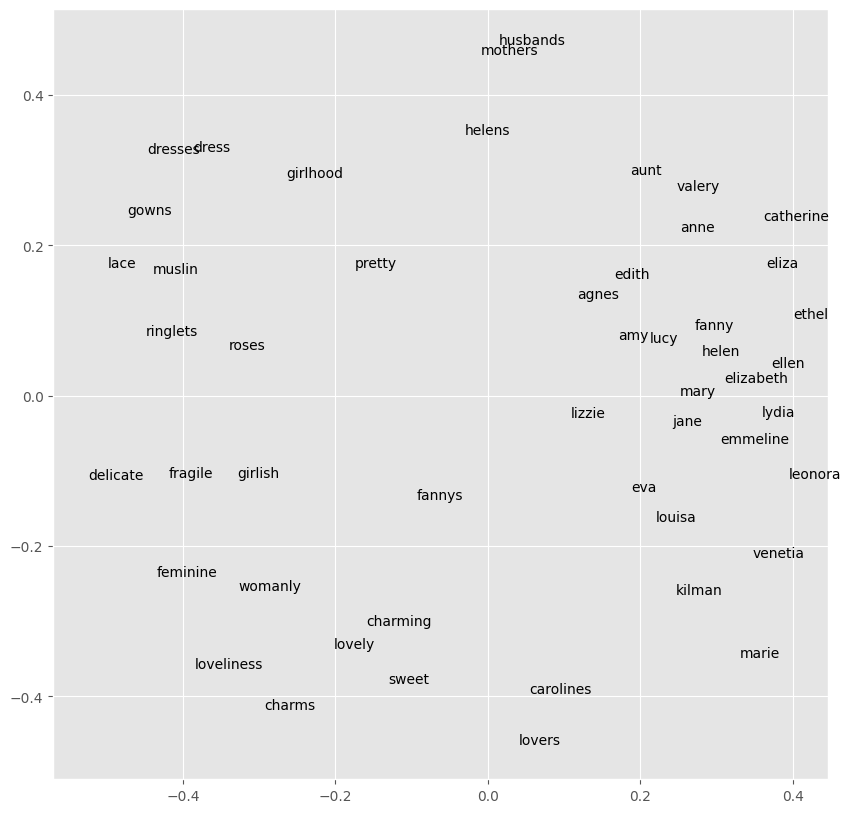

In [47]:
# Make a pretty graph

_, ax = plt.subplots(figsize=(10,10))
ax.scatter(embeddings[:,0], embeddings[:,1], alpha=0)
for i in range(len(vectors)):
    ax.annotate(her_tokens[i], ((embeddings[i,0], embeddings[i,1])))

/Users/angela/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


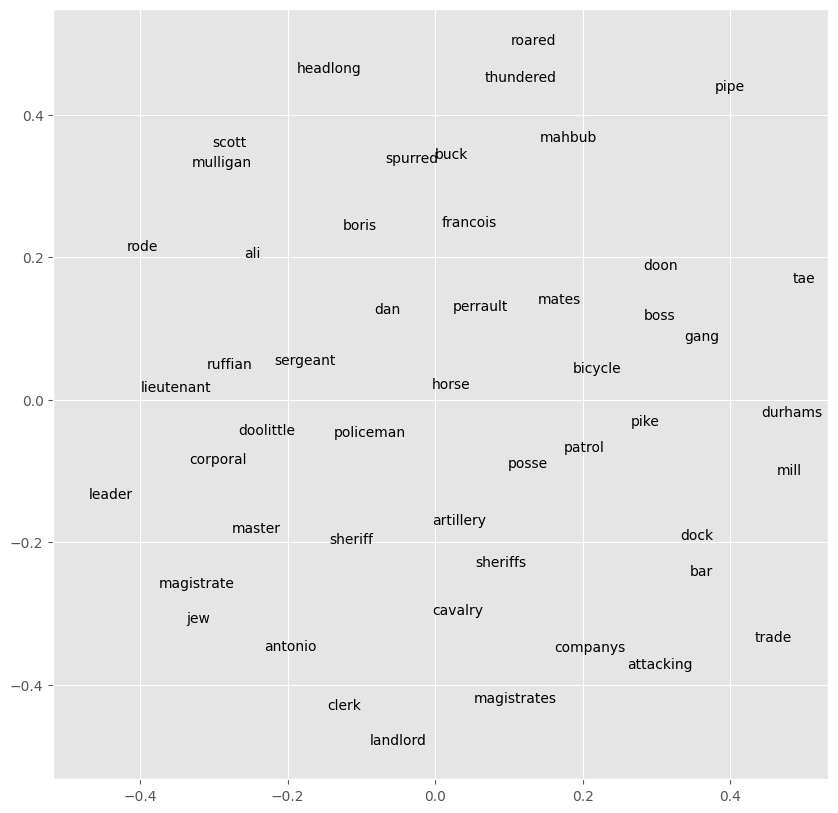

In [48]:
# For comparison, here is the same graph using a masculine-pronoun vector

his_tokens = [token for token,weight in model.wv.most_similar(positive=['he','him','his','himself'], \
                                                       negative=['she','her','hers','herself'], topn=50)]
vectors = [model.wv.get_vector(word) for word in his_tokens]
dist_matrix = pairwise.pairwise_distances(vectors, metric='cosine')
mds = MDS(n_components = 2, dissimilarity='precomputed')
embeddings = mds.fit_transform(dist_matrix)
_, ax = plt.subplots(figsize=(10,10))
ax.scatter(embeddings[:,0], embeddings[:,1], alpha=0)
for i in range(len(vectors)):
    ax.annotate(his_tokens[i], ((embeddings[i,0], embeddings[i,1])))

Q. What kinds of semantic relationships exist in the diagram above?

Are there any words that seem out of place?

# 3. Saving/Loading Models

In [49]:
# Save current model for later use

model.save('resources/word2vec.txtlab_Novel150_English.bin')
#model.save_word2vec_format('resources/word2vec.txtlab_Novel150_English.txt') # deprecated

In [50]:
# Load up models from disk

# Model trained on Eighteenth Century Collections Online corpus (~2500 texts)
# Made available by Ryan Heuser: http://ryanheuser.org/word-vectors-1/

ecco_model = gensim.models.KeyedVectors.load_word2vec_format('resources/word2vec.ECCO-TCP.txt')
#ecco_model = gensim.models.Word2Vec.load_word2vec_format('resources/word2vec.ECCO-TCP.txt') # deprecated

In [51]:
# What are similar words to BANK?

ecco_model.most_similar('bank')

[('ground', 0.657000720500946),
 ('turf', 0.6564096808433533),
 ('surface', 0.6480724811553955),
 ('declivity', 0.642420768737793),
 ('hill', 0.637111485004425),
 ('bridge', 0.6332241296768188),
 ('terrace', 0.6301186680793762),
 ('channel', 0.629577100276947),
 ('banks', 0.629473865032196),
 ('wall', 0.6289102435112)]

In [52]:
# What if we remove the sense of "river bank"?

ecco_model.most_similar(positive=['bank'], negative=['river'])

[('currency', 0.36714258790016174),
 ('suit', 0.35922905802726746),
 ('stamp', 0.3582037687301636),
 ('promissory', 0.35605302453041077),
 ('pension', 0.35183218121528625),
 ('blank', 0.3518177568912506),
 ('payable', 0.34270504117012024),
 ('mortality', 0.3426245450973511),
 ('weekly', 0.34080609679222107),
 ('weal', 0.3309360146522522)]

## Exercises!

In [53]:
## EX. Use the most_similar method to find the tokens nearest to 'car' in either model.
##     Do the same for 'motorcar'.

## Q.  What characterizes these two words inthe corpus? Does this make sense?

model.wv.most_similar('car')

[('hansom', 0.7916545867919922),
 ('tram', 0.7584871053695679),
 ('team', 0.75579434633255),
 ('wagon', 0.7412554025650024),
 ('ferryboat', 0.7369030117988586),
 ('buggy', 0.7345541715621948),
 ('bus', 0.7344121336936951),
 ('carryall', 0.732768714427948),
 ('cab', 0.7283746600151062),
 ('truck', 0.7254972457885742)]

In [54]:
model.wv.most_similar('motorcar')

[('saucepan', 0.7595863938331604),
 ('steamed', 0.755942702293396),
 ('shack', 0.7547856569290161),
 ('scullery', 0.7535364031791687),
 ('pail', 0.7527008056640625),
 ('ferryboat', 0.7506797313690186),
 ('skiff', 0.7490808963775635),
 ('jewellers', 0.745529055595398),
 ('carahers', 0.7435512542724609),
 ('jingled', 0.7416866421699524)]

In [55]:
## EX. How does our model answer the analogy: MADRID is to SPAIN as PARIS is to __________

## Q.  What has our model learned about nation-states?


model.wv.most_similar(positive=['paris', 'spain'], negative = ['madrid'])

[('italy', 0.7666966319084167),
 ('germany', 0.7548961639404297),
 ('greece', 0.6732473373413086),
 ('france', 0.6684234738349915),
 ('america', 0.6642230153083801),
 ('england', 0.6536044478416443),
 ('europe', 0.6482828855514526),
 ('india', 0.62784343957901),
 ('rome', 0.6122703552246094),
 ('persia', 0.5902167558670044)]

In [56]:
## EX. Perform the canonic Word2Vec addition again but leave out a term:
##     Try 'king' - 'man', 'woman' - 'man', 'woman' + 'king'

## Q.  What do these indicate semantically?

model.wv.most_similar(positive= ['woman'], negative=['man'])

[('emmeline', 0.4613833725452423),
 ('jane', 0.44158676266670227),
 ('ethel', 0.4301283359527588),
 ('maid', 0.4259932041168213),
 ('charms', 0.42520514130592346),
 ('louisa', 0.4157273769378662),
 ('eliza', 0.41225242614746094),
 ('aunt', 0.4076521396636963),
 ('gowns', 0.40429073572158813),
 ('lucy', 0.40420451760292053)]

In [57]:
## EX. Heuser's blog post explores an analogy in eighteenth-century thought that
##     RICHES are to VIRTUE what LEARNING is to GENIUS. How true is this in
##     the ECCO-trained Word2Vec model? Is it true in the one we trained?

##  Q. How might we compare word2vec models more generally?


In [58]:
# ECCO model: RICHES are to VIRTUE what LEARNING is to ??

ecco_model.most_similar(positive=['learning', 'virtue'], negative=['riches'])

[('piety', 0.7372761964797974),
 ('morality', 0.7266899943351746),
 ('science', 0.6974709630012512),
 ('prudence', 0.6855395436286926),
 ('philosophy', 0.683079183101654),
 ('wisdom', 0.6511391997337341),
 ('genius', 0.6505820155143738),
 ('humanity', 0.640283465385437),
 ('modesty', 0.6369403004646301),
 ('morals', 0.6340599060058594)]

In [59]:
# txtLab model: RICHES are to VIRTUE what LEARNING is to ??
model.wv.most_similar(positive=['learning', 'virtue'], negative=['riches'])

[('teaching', 0.6103702187538147),
 ('literal', 0.5843766331672668),
 ('poetry', 0.569068193435669),
 ('mathematics', 0.5656746625900269),
 ('moralist', 0.563969075679779),
 ('yankee', 0.5564850568771362),
 ('critic', 0.5527565479278564),
 ('logic', 0.5465735793113708),
 ('jargon', 0.5463364124298096),
 ('literature', 0.5447049140930176)]

# 4. Open Questions
At this point, we have seen a number of mathemetical operations that we may use to explore word2vec's word embeddings. These enable us to answer a set of new, interesting questions dealing with semantics, yet there are many other questions that remain unanswered.

For example:
<ol>
<li>How to compare word usages in different texts (within the same model)?</li>
<li>How to compare word meanings in different models? compare whole models?</li>
<li>What about the space “in between” words?</li>
<li>Do we agree with the Distributional Hypothesis that words with the same contexts share their meanings?</li>
<ol><li>If not, then what information do we think is encoded in a word’s context?</li></ol>
<li>What good, humanistic research questions do analogies shed light on?</li>
<ol><li>shades of meaning?</li><li>context similarity?</li></ol>
</ol>